In [6]:
import json 
with open('padel-data-labels/labels/2022_BCN_FinalF_1_ball.json','r') as f :
    data = f.read()
data =   json.loads(data)

In [ ]:
#Print all keys for the json file  
for key in data.keys():
    print(key)

licenses
info
categories
images
annotations


In [14]:
ball_categorie ={}
for category in data['categories']: 
    if(category["name"] == "Ball"):
        ball_categorie = category
images_data = {}
for image in data['images']:
    images_data[image['id']] = image
##merge the data of the ball and the image 
ball_data = {}
for annotation in data['annotations']:
    if(annotation["category_id"] == ball_categorie["id"]):
        ball_data[annotation["id"]] = {
            'image_id' :  images_data[annotation['image_id']]['file_name'],
            'bbox' : annotation['bbox'],
            "area" : annotation['area'],
        }
print(ball_data[1])        

{'image_id': 'frame_000000.PNG', 'bbox': [864.45, 338.02, 7.98, 7.66], 'area': 61.12679999999947}


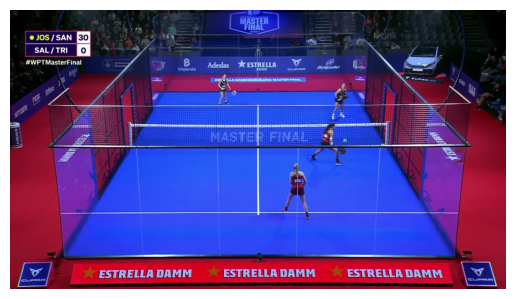

In [29]:
import cv2
import matplotlib.pyplot as plt
import os

# Build the image path
img_path = f"frames/frames_finalF/{ball_data[1001]['image_id']}"

# Check the path
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")

# Load the image (BGR format)
image_bgr = cv2.imread(img_path)

# Draw a rectangle (x1, y1) → (x2, y2) in green
x_min, y_min, w_box, h_box = ball_data[1000]['bbox']

x1 = int(x_min)
y1 = int(y_min)
x2 = int(x_min + w_box)
y2 = int(y_min + h_box)

cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# Show in notebook
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
